In [3]:
import pandas as pd
import geopandas as gpd
import folium
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(
    r"C:\Users\harun\OneDrive\Desktop\earthquake-data-analysis-project-harita-berkay\data\processed\depremler_ve_faylar_birlestirilmis.csv", 
    parse_dates=['Date'] # Senin tarih sütununun adı neyse onu yaz (örn: 'Olus_Tarihi')
)

In [5]:
fay_hatlari = gpd.read_file(r"C:\Users\harun\OneDrive\Desktop\earthquake-data-analysis-project-harita-berkay\data\raw\DFY_GEO_WGS84_2013_s.shp").to_crs("EPSG:4326")

In [6]:
m = folium.Map(location=[39.0, 35.0], zoom_start=6, tiles="CartoDB positron")

In [7]:
fay_katmani = folium.FeatureGroup(name="Fay Hatları")

In [8]:
deprem_katmani = folium.FeatureGroup(name="Deprem Kümeleri (Cluster)")

In [9]:
isi_katmani = folium.FeatureGroup(name="Deprem Yoğunluğu (Heatmap)", show=False)

In [10]:
folium.GeoJson(
    fay_hatlari,
    style_function=lambda x: {'color': 'red', 'weight': 1.5, 'opacity': 0.5},
    tooltip=folium.GeoJsonTooltip(fields=['FAYADI'], aliases=['Fay:'])
).add_to(fay_katmani)

In [11]:
marker_cluster = MarkerCluster().add_to(deprem_katmani)

In [12]:
for i, row in df.head(5000).iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']], # Enlem, Boylam
        radius=3, # Nokta büyüklüğü
        color='blue',
        fill=True,
        fill_color='blue',
        popup=f"Büyüklük: {row['Magnitude']} <br> Tarih: {row['Date']} <br> Fay: {row['FAYADI']}"
    ).add_to(marker_cluster)

In [13]:
isi_verisi = df[['Latitude', 'Longitude', 'Magnitude']].values.tolist()

In [14]:
HeatMap(isi_verisi, radius=10, blur=15).add_to(isi_katmani)

In [15]:
fay_katmani.add_to(m)
deprem_katmani.add_to(m)
isi_katmani.add_to(m)

In [16]:
folium.LayerControl(collapsed=False).add_to(m)

In [17]:
m.save(r"C:\Users\harun\OneDrive\Desktop\earthquake-data-analysis-project-harita-berkay\outputs\maps\interaktif_analiz_haritasi.html")

In [18]:
top_faylar = df['FAYADI'].value_counts().head(10).reset_index()

In [19]:
top_faylar.columns = ['Fay Adı', 'Deprem Sayısı']

In [20]:
fig = px.bar(
    top_faylar, 
    x='Deprem Sayısı', 
    y='Fay Adı', 
    orientation='h', # Yatay çubuk
    title="Türkiye'de En Çok Deprem Üreten 10 Fay Hattı (1915-Günümüz)",
    color='Deprem Sayısı',
    color_continuous_scale='Viridis'
)
fig.show()

In [19]:
df['Yil'] = df['Date'].dt.year

In [20]:
yil_bazli = df['Yil'].value_counts().sort_index().reset_index()
yil_bazli.columns = ['Yil', 'Deprem Sayısı']

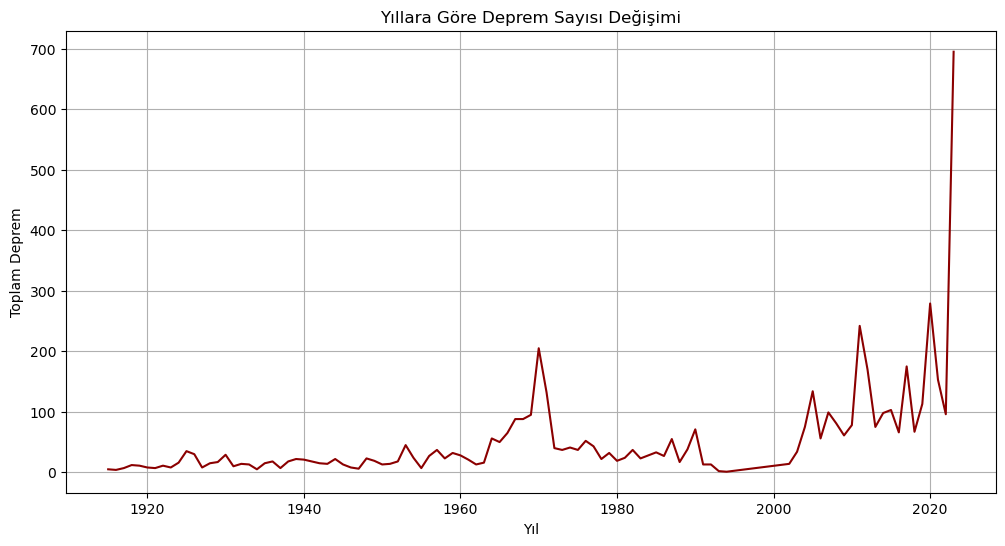

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=yil_bazli, x='Yil', y='Deprem Sayısı', color='darkred')
plt.title("Yıllara Göre Deprem Sayısı Değişimi")
plt.xlabel("Yıl")
plt.ylabel("Toplam Deprem")
plt.grid(True)
plt.show()

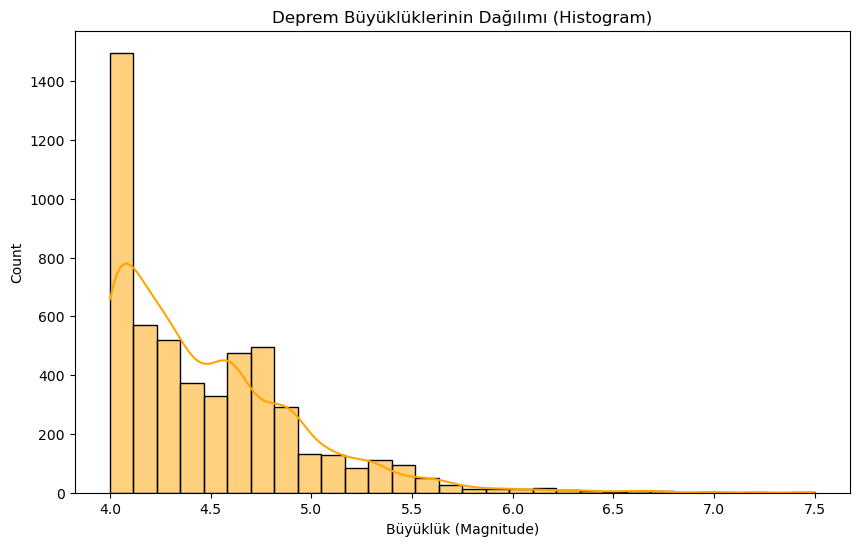

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Magnitude'], bins=30, kde=True, color='orange')
plt.title("Deprem Büyüklüklerinin Dağılımı (Histogram)")
plt.xlabel("Büyüklük (Magnitude)")
plt.show()

In [23]:
filtreli_df = df[(df['Magnitude'] > 4.0) & (df['Yil'] > 1915)].sort_values("Yil")

In [24]:
fig_anim = px.scatter_geo(
    filtreli_df,
    lat='Latitude',
    lon='Longitude',
    color='Magnitude', # Büyüklüğe göre renk
    size='Magnitude',  # Büyüklüğe göre nokta boyutu
    animation_frame='Yil', # ZAMANI OYNATAN KISIM BURASI
    scope='europe', # Harita odağı
    title="Yıllara Göre 4.0+ Büyüklüğündeki Depremlerin Animasyonu",
    color_continuous_scale='Reds'
)

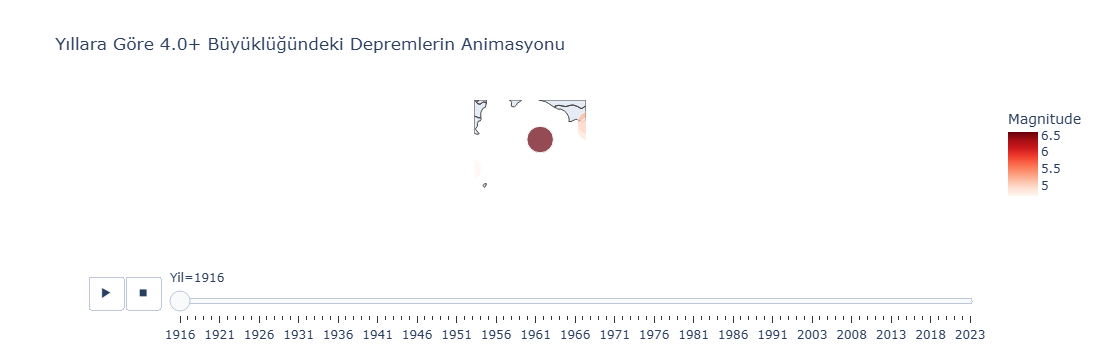

In [25]:
fig_anim.update_geos(
    center=dict(lon=35, lat=39), 
    projection_scale=6 # Zoom seviyesi (Deneyerek ayarla)
)

In [30]:
fig_anim.write_html(r"C:\Users\harun\OneDrive\Desktop\earthquake-data-analysis-project-harita-berkay\outputs/zaman_animasyonu.html")